# 尝试找到 headland 的平滑外形，但是还需要保证外形不超过地块本身

In [1]:
import geopandas as gpd
from shapely import LineString, Polygon, Point
import shapely
from shapely import ops
import matplotlib.pyplot as plt
from CPP_Planner import CPP_Algorithms, CPP_Planner_Kit
from shapely import affinity

In [2]:
all_land = gpd.read_file('test_Load_Shp/shp_file/村1地_全区.shp')
all_land.geometry = all_land.geometry.apply(shapely.set_precision, grid_size=0.05)
all_land

,NAME,LAYER,周长,闭合面积,geometry
0,地2,Unknown Area Type,315.38 m,0.001833 sq km,"POLYGON ((440417.600 4397401.450, 440401.850 4..."
1,地3,Unknown Area Type,182.65 m,0.001528 sq km,"POLYGON ((440478.950 4397335.400, 440484.500 4..."
2,地4,Unknown Area Type,247.41 m,0.00125 sq km,"POLYGON ((440472.250 4397608.050, 440469.000 4..."
3,地5,Unknown Area Type,143.98 m,0.000743 sq km,"POLYGON ((440450.050 4397795.250, 440451.850 4..."
4,地6,Unknown Area Type,120.25 m,0.000631 sq km,"POLYGON ((440352.800 4397768.750, 440351.250 4..."
5,地7,Unknown Area Type,147.18 m,0.001222 sq km,"POLYGON ((440315.750 4397785.800, 440309.100 4..."
6,地1_区,Unknown Area Type,442.09 m,0.004246 sq km,"POLYGON ((440410.850 4397414.750, 440398.850 4..."


<Axes: >

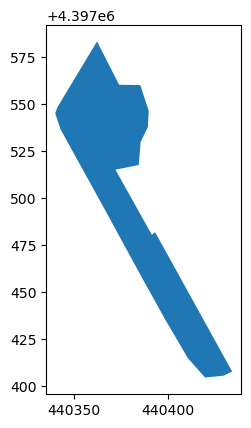

In [3]:
single_land = CPP_Planner_Kit.get_single_shp(all_land, 6)
single_land.plot()

split_polygon_by_largest_area： 开始进行田块分割，当前误差范围 tolerance = 0.04
Num of convex_hull:  12
Num of Polygon lines:  20
Not on Convex:  11
Num of convex_hull:  7
Num of Polygon lines:  9
Not on Convex:  4


/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


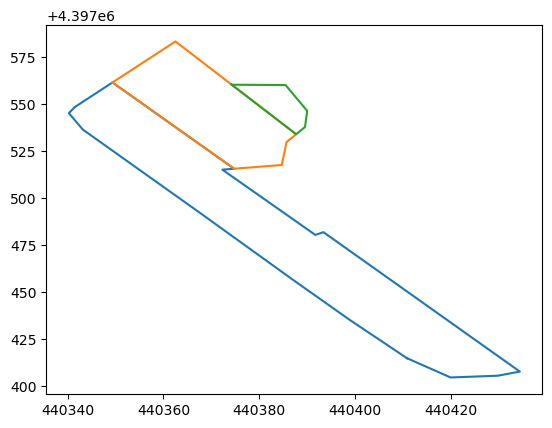

In [4]:
split_polygon = CPP_Planner_Kit.split_polygon_by_largest_area(single_land.geometry.iloc[0], tolerance=0.04)
fig, ax = plt.subplots()
for polygon in split_polygon:
    ax.plot(*polygon.exterior.xy)

In [5]:
single_polygon = split_polygon[1]
# 将其旋转到水平
single_polygon_angle = CPP_Planner_Kit.get_land_MABR_angle(single_polygon)
single_polygon = affinity.rotate(single_polygon, -single_polygon_angle, origin='centroid')
single_polygon = shapely.set_precision(single_polygon, 0.05)
print(single_polygon)

当前田块角度： 117.06086972480475
POLYGON ((440404.15 4397537.05, 440378.35 4397537.05, 440348.75 4397537.05, 440346 4397540.75, 440335.55 4397547.2, 440338.3 4397556.95, 440390.75 4397558.7, 440404.15 4397537.05))


/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:1000: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)


/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:1000: RuntimeWarning: divide by zero encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)


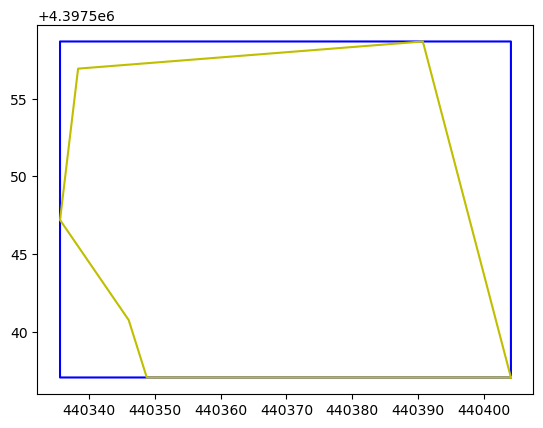

In [6]:
# 显示最小旋转外接矩形和多边形本身
mabr = single_polygon.minimum_rotated_rectangle
fig, ax = plt.subplots()
x, y = mabr.exterior.xy
ax.plot(x, y, 'b')
x, y = single_polygon.exterior.xy
ax.plot(x, y, 'y')

In [7]:
# 获取规划地块和地头区域
single_polygon_regen = gpd.GeoDataFrame(geometry=[single_polygon], crs=all_land.crs)
path, headland = CPP_Algorithms.scanline_algorithm_single_with_headland(single_polygon_regen, 1.4, True, headland='left', head_land_width=6)

当前田块角度： -179.99994902253113


/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:1000: RuntimeWarning: divide by zero encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:1000: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in diff

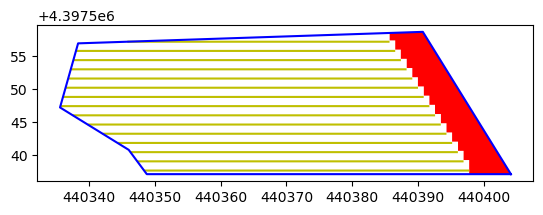

In [8]:
# 显示结果
fig, ax = plt.subplots()
path.plot(ax=ax, color='y')
headland.plot(ax=ax, color='r')
ax.plot(*single_polygon.exterior.xy, color='b')
plt.show()

In [9]:
# 现在需要保证 headland 一定在地块内部
headland_inter = headland.intersection(single_polygon_regen)

/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


<Axes: >

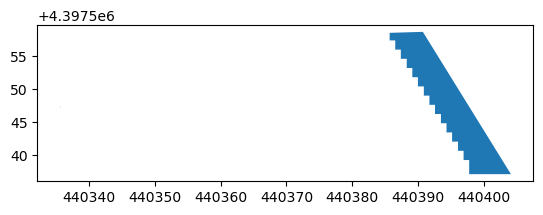

In [10]:
headland_inter.plot()

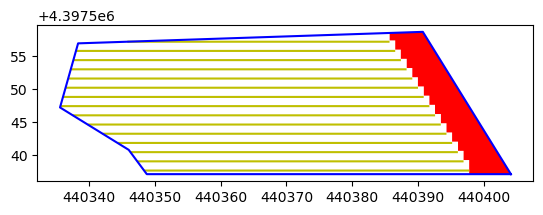

In [11]:
# 重新显示
fig, ax = plt.subplots()
path.plot(ax=ax, color='y')
headland_inter.plot(ax=ax, color='r')
ax.plot(*single_polygon.exterior.xy, color='b')
plt.show()